In [240]:
# Import necessary packages
import os
import pathlib
import pandas as pd # Aggregating, data manipulation
import re # Parsing information out of file names
import rioxarray as rxr # Work with raster data
from rioxarray.merge import merge_arrays # Merge rasters
import geopandas as gpd # Work with vector data
import hvplot.pandas
import xrspatial
from math import floor, ceil

# High-Level Project Description

In this project, you will create a habitat suitability model for Sorghastrum nutans (or a plant species of your choice), a grass native to North America. In the past 50 years, its range has moved northward. The model will be based on combining multiple data layers related to soil, topography, and climate. You will also demonstrate the coding skills covered in this class by creating a modular, reproducible workflow for the model.

# National Grasslands and Habitata

All but four national grasslands are on or at the edge of the Great Plains. Those four are in southeastern Idaho, northeastern California, central Oregon, and a reserve in Illinois [Wikipedia National Grasslands](https://en.wikipedia.org/wiki/National_grassland). As of September 30, 2007, the total area of all 20 national grasslands was 3,838,280 acres (1,553,300 ha).[1]

## Sorghastrum nutans (Yellow Indian Grass)
 Yellow indian grass is a tall, bunching sod-former, 3-8 ft. in height, with broad blue-green blades and a large, plume-like, soft, golden-brown seed head. This showy perennial’s fall color is deep orange to purple.

This is a beautiful grass with a somewhat metallic golden sheen to its flowering parts. It is an important associate in the tallgrass prairies and is relished by livestock. It appears to be favored by occasional flooding and repeated burning and sometimes forms nearly pure stands in the lowlands. Warm-season grass with rich gold-and-purple sprays of flowers and seeds in the fall. (Ontario Native Plants 2002) 

### Distribution
USA: AL , AR , AZ , CO , CT , DC , DE , FL , GA , IA , IL , IN , KS , KY , LA , MA , MD , ME , MI , MN , MO , MS , NC , ND , NE , NH , NJ , NM , NY , OH , OK , PA , RI , SC , SD , TN , TX , UT , VA , VT , WI , WV , WY
Canada: MB , NB , ON , QC , SK
Native Distribution: Que. & ME to Man., s. to FL & AZ, then south to Chiapas in southern Mexico
Native Habitat: Prairies; open woods; fields; dry slopes. Frequent in north central Texas, Edwards Plateau, and Plains Country. Sand, loam, clay, limestone; seasonal poor drainage okay.

### Growing Conditions
Water Use: Medium
Light Requirement: Sun , Part Shade , Shade
Soil Moisture: Dry , Moist
CaCO3 Tolerance: High
Drought Tolerance: High
Soil Description: Moist, rich soils. Calcareous, Sandy Sandy Loam, Medium Loam, Clay Loam, Clay, Limestone-based
Conditions Comments: Along with little bluestem, big bluestem and switchgrass, Indian grass is an important species in the tallgrass prairie. The bright yellow flowers contrast attractively with the blue-gray foliage. The grass stays low most of the year and then gets tall before blooming in early autumn. Like little bluestem, Indian grass is best planted en masse or in a wildflower meadow. 
Reference: https://www.wildflower.org/plants/result.php?id_plant=SONU2

In [241]:
# Set up a project data directory

# Step 1: Get the home folder path
home_folder = os.path.expanduser("~")

# Step 2: Define the project directory within the home folder
project_dir = os.path.join(
    pathlib.Path.home(),
    'earth-analytics',
    'data',
    'habitat_suitability',
)

# Step 3: Create the project directory if it doesn't already exist
os.makedirs(project_dir, exist_ok=True)

# Step 4: Confirm creation
print(f"Project directory created at: {project_dir}")

os.makedirs(project_dir, exist_ok=True)

Project directory created at: /Users/erinzimmerman/earth-analytics/data/habitat_suitability


In [242]:
# Set up the USFS National Grassland Units boundary URL
habitat_url = (
    "https://data.fs.usda.gov"
    "/geodata/edw/edw_resources/shp/"
    "S_USA.NationalGrassland.zip"
)

# Set up a path to save the data on your machine
habitat_dir = os.path.join(project_dir, 'usfs_grassland')

# Make the USFS National Grassland Units directory
os.makedirs(habitat_dir, exist_ok=True)

# Join USFS National Grassland Units shapefile path
habitat_path = os.path.join(habitat_dir, 'usfs_grassland.shp')

# Only download once
if not os.path.exists(habitat_path):
    habitat_gdf = gpd.read_file(habitat_url)
    habitat_gdf.to_file(habitat_path)

# Load from file
habitat_gdf = gpd.read_file(habitat_path)

In [123]:
habitat_gdf.head(19)
                 

,NATIONALGR,GRASSLANDN,GIS_ACRES,SHAPE_AREA,SHAPE_LEN,geometry
0,281771010328,Fort Pierre National Grassland,209044.225,0.095149,1.455518,"POLYGON ((-100.08409 44.28162, -100.08409 44.2..."
1,295507010328,Butte Valley National Grassland,19489.170,0.008557,0.853736,"MULTIPOLYGON (((-121.996 41.84049, -121.996 41..."
2,295508010328,Kiowa National Grassland,144281.321,0.058543,9.858642,"MULTIPOLYGON (((-104.30414 36.08063, -104.3041..."
3,295509010328,Sheyenne National Grassland,70428.175,0.033356,4.097398,"MULTIPOLYGON (((-97.31081 46.51457, -97.30559 ..."
4,295510010328,Cedar River National Grassland,6717.517,0.003157,0.999947,"MULTIPOLYGON (((-101.82221 45.95896, -101.8170..."
5,295511010328,Black Kettle National Grassland,33103.349,0.013340,4.561060,"MULTIPOLYGON (((-99.91659 35.71892, -99.91661 ..."
6,295512010328,Rita Blanca National Grassland,94127.091,0.038271,6.652113,"MULTIPOLYGON (((-102.62993 36.44072, -102.6298..."
7,295513010328,Thunder Basin National Grassland,626249.208,0.282888,44.088050,"MULTIPOLYGON (((-105.46005 43.31908, -105.4601..."
8,295514010328,McClellan Creek National Grassland,1401.715,0.000562,0.115902,"POLYGON ((-100.86003 35.20951, -100.86008 35.2..."
9,295515010328,Caddo National Grassland,68479.549,0.026940,1.159342,"MULTIPOLYGON (((-95.85492 33.79814, -95.85494 ..."


# A Note on the Data
A [National Grassland unit](https://data.fs.usda.gov/geodata/edw/edw_resources/shp/S_USA.NationalGrassland.zip) designated by the Secretary of Agriculture and permanently held by the Department of Agriculture under Title III of the Bankhead-Jones Farm Tenant Act.

This data is intended for read-only use. These data were prepared to describe Forest Service administrative area boundaries. The purpose of the data is to provide display, identification, and analysis tools for determining current boundary information for Forest Service managers, GIS Specialists, and others.

# Study Area(s)

### Sheyenne National Grassland

Our first study areas is Sheyenne National Grassland, located in southeastern North Dakota, comprising 70,180 acres (28,400 ha) of public land amid 64,769 acres (26,211 ha) of privately owned land. It is characterized by sandy soils, originally deposited as the delta of an ancient river as it emptied into glacial Lake Agassiz. Since that time, wind and rain have shaped the topography into a unique landscape ranging from flat deltaic plains to choppy sand dunes.

It is the only National Grassland in the tallgrass prairie region of the United States.


In [243]:
# select data from Sheyenne National Grassland only
habitat1_gdf = habitat_gdf[habitat_gdf.GRASSLANDN=='Sheyenne National Grassland']
habitat1_gdf.dissolve().hvplot(
    geo=True, tiles='EsriImagery',
    title='Sheyenne National Grassland',
    fill_color=None, line_color='red', line_width=3,
    frame_width=600
)

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]

In [269]:
# Define bounds for Sheyanne National Grasslands
habitat1_bounds = bounds_min_lon, bounds_min_lat, bounds_max_lon, bounds_max_lat = (
    habitat1_gdf.total_bounds)

# Soil Data 
Soil data was drawn from the POLARIS Database hosted at Duke University. 

## Method
Soil Ph was selected as the first variable and moisture for the second. The mean of each was used as it is most representative of the 'average' found within each area of interest.

Samples from a soil depth of XX were selected as that is the center of the root depth of Sorghastrum nutans. In general, this species is robust and found in a diversity of soil types. 

In [270]:
# # Define bounds for Sheyanne National Grasslands
habitat1_bounds = bounds_min_lon, bounds_min_lat, bounds_max_lon, bounds_max_lat = (
    habitat1_gdf.total_bounds)

# Define the download URL for the study area (Polaris Data). 
# This data is for the Ph of the soil for Sheyanne National Grassland
soil1_url_template = ("http://hydrology.cee.duke.edu"
            "/POLARIS/PROPERTIES/v1.0"
            "/ph"
            "/mean"
            "/30_60/"
            "lat{min_lat}{max_lat}_lon{min_lon}{max_lon}.tif"
)

soil1_url = soil1_url_template.format(
        min_lat=46, max_lat=47, min_lon=-96, max_lon=-98)
soil1_url

'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/30_60/lat4647_lon-96-98.tif'

In [279]:
soil1_url_list = []
for min_lon in range(floor(bounds_min_lon), ceil(bounds_max_lon)):
    for min_lat in range(floor(bounds_min_lat), ceil(bounds_max_lat)):
        soil1_url = soil1_url_template.format(
            min_lat=min_lat, max_lat=min_lat+1,
            min_lon=min_lon, max_lon=min_lon+1)
        soil1_url_list.append(soil1_url)
soil1_url_list


['http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/30_60/lat4647_lon-98-97.tif',
 'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/30_60/lat4647_lon-97-96.tif']

In [287]:
soil1_das = []
#loop through each of the soil files
for i in soil1_url_list:
    # Download raster data
    # Unzip the raster data
    # Extract metadada from the file name
     # Only download once -- Save raster data to the disk
     # with zipfile.ZipFile(BytesIO(response.content)) as hls_zip:
    #  hls_zip.extractall(hls_dir)
     # Load the raster data into Python, mask and scale and squeeze
    soil1_da = rxr.open_rasterio(
         i,
         mask_and_scale=True
         ).squeeze()
    print('OPENED ')

    # Crop the raster data
    cropped1_da = soil1_da.rio.clip_box(*habitat1_bounds) 
    soil1_das.append(cropped1_da)
    print('CROPPED')


OPENED 
CROPPED
OPENED 
CROPPED


In [ ]:
print(soil1_das)

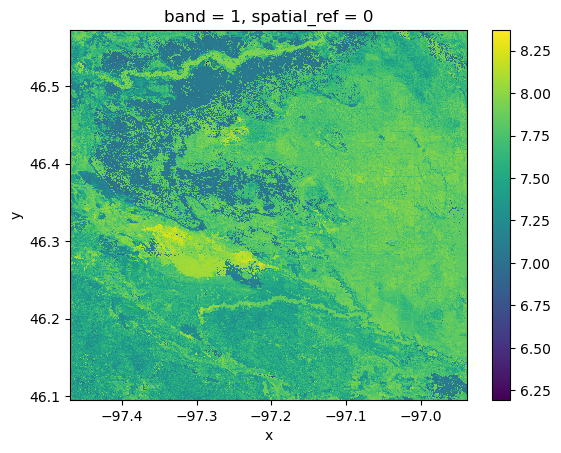

In [289]:
# Merge tiles
soil1_merged_das = merge_arrays(soil1_das)
soil1_merged_das.plot()

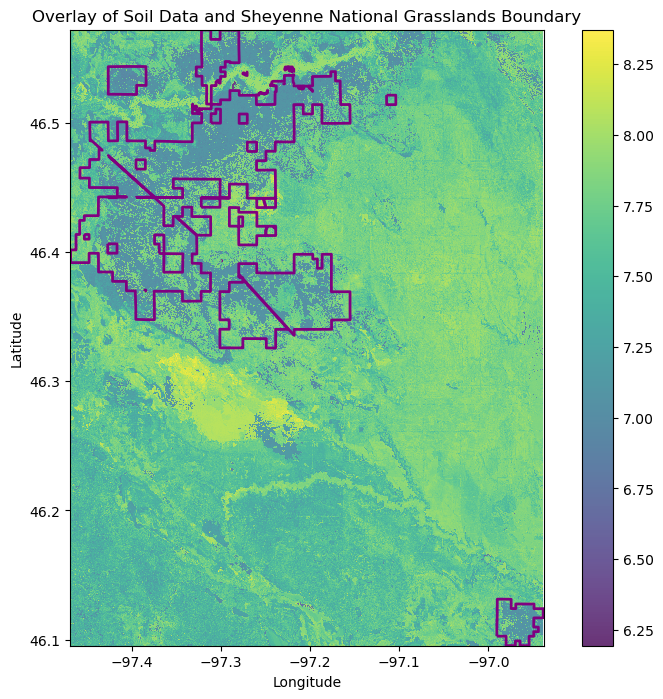

In [291]:
# Create a plot
fig1, ax = plt.subplots(figsize=(10, 8))

# Plot the raster data (soil1_das)
soil1_merged_das.plot(ax=ax, cmap="viridis", alpha=0.8)  # Adjust alpha for transparency

# Plot the boundaries of the vector data (habitat1_gdf)
habitat1_gdf.boundary.plot(ax=ax, color='purple', linewidth=2)

# Add title and labels
ax.set_title("Overlay of Soil Data and Sheyenne National Grasslands Boundary")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show the plot
plt.show()

# Analysis site #2 - Little Missouri National Grassland

The second study area is Little Missouri National Grassland.The largest National Grassland, Little Missouri includes badlands and short and long grass prairie. 

The Little Missouri National Grassland was once a part of the Custer National Forest, but is now a part of the Dakota Prairie Grasslands, a National Forest unit consisting entirely of National Grasslands. A predominant feature of the grassland is colorful and beautiful badlands, a rugged terrain extensively eroded by wind and water. It is a mixed-grass prairie with both long and short grass.[4][5]

The Little Missouri River meanders through the grassland and White Butte, North Dakota's highest point, is located in the extreme southeast corner, south of the town of Amidon.[Little Missouri National Grassland](https://en.wikipedia.org/wiki/Little_Missouri_National_Grassland)

In [127]:
# Site 2
# select data from Little Missouri National Grassland
habitat2_gdf = habitat_gdf[habitat_gdf.GRASSLANDN=='Little Missouri National Grassland']
habitat2_gdf.dissolve().hvplot(
    geo=True, tiles='EsriImagery',
    title='Little Missouri National Grassland',
    fill_color=None, line_color='red', line_width=3,
    frame_width=800
)

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]

In [160]:
# Define the download URL for the study area (Polaris Data). 
# This data is for the Ph of the soil (This is for the second study area of Little Missouri National Grassland)
soil2_url_template = ("http://hydrology.cee.duke.edu"
            "/POLARIS/PROPERTIES/v1.0"
            "/ph"
            "/mean"
            "/30_60/"
            "lat{min_lat}{max_lat}_lon{min_lon}{max_lon}.tif"
)

soil2_url = soil2_url_template.format(
        min_lat=49, max_lat=49, min_lon=-102, max_lon=-105)
soil2_url

'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/30_60/lat4949_lon-102-105.tif'

In [223]:
# Define bounds for Missouri Grasslands 
soil2_bounds = bounds_min_lon, bounds_min_lat, bounds_max_lon, bounds_max_lat = (
    habitat2_gdf.total_bounds)


soil2_url_list = []
for min_lon in range(floor(bounds_min_lon), ceil(bounds_max_lon)):
    for min_lat in range(floor(bounds_min_lat), ceil(bounds_max_lat)):
        soil2_url = soil2_url_template.format(
            min_lat=min_lat, max_lat=min_lat+1,
            min_lon=min_lon, max_lon=min_lon+1)
        soil2_url_list.append(soil2_url)
soil2_url_list

soil2_das = []
#loop through each of the soil files
for i in soil2_url_list:
    # Download raster data
    # Unzip the raster data
    # Extract metadada from the file name
     # Only download once -- Save raster data to the disk
     # with zipfile.ZipFile(BytesIO(response.content)) as hls_zip:
    #  hls_zip.extractall(hls_dir)
     # Load the raster data into Python, mask and scale and squeeze
     soil2_da = rxr.open_rasterio(
         i,
         mask_and_scale=True
         ).squeeze()
     print('OPENED ')

     #Crop the raster data
     cropped2_da = soil2_da.rio.clip_box(*habitat2_bounds) 
     soil2_das.append(cropped2_da)
     print('CROPPED')

display(soil2_das)


OPENED 
CROPPED
OPENED 
CROPPED
OPENED 
CROPPED
OPENED 
CROPPED
OPENED 
CROPPED
OPENED 
CROPPED
OPENED 
CROPPED
OPENED 
CROPPED
OPENED 
CROPPED


[<xarray.DataArray (y: 2592, x: 165)> Size: 2MB
 [427680 values with dtype=float32]
 Coordinates:
     band         int64 8B 1
   * x            (x) float64 1kB -104.0 -104.0 -104.0 ... -104.0 -104.0 -104.0
   * y            (y) float64 21kB 47.0 47.0 47.0 47.0 ... 46.28 46.28 46.28
     spatial_ref  int64 8B 0
 Attributes:
     AREA_OR_POINT:  Area,
 <xarray.DataArray (y: 3600, x: 165)> Size: 2MB
 [594000 values with dtype=float32]
 Coordinates:
     band         int64 8B 1
   * x            (x) float64 1kB -104.0 -104.0 -104.0 ... -104.0 -104.0 -104.0
   * y            (y) float64 29kB 48.0 48.0 48.0 48.0 ... 47.0 47.0 47.0 47.0
     spatial_ref  int64 8B 0
 Attributes:
     AREA_OR_POINT:  Area,
 <xarray.DataArray (y: 451, x: 165)> Size: 298kB
 [74415 values with dtype=float32]
 Coordinates:
     band         int64 8B 1
   * x            (x) float64 1kB -104.0 -104.0 -104.0 ... -104.0 -104.0 -104.0
   * y            (y) float64 4kB 48.13 48.12 48.12 48.12 ... 48.0 48.0 48.0 48.0
   

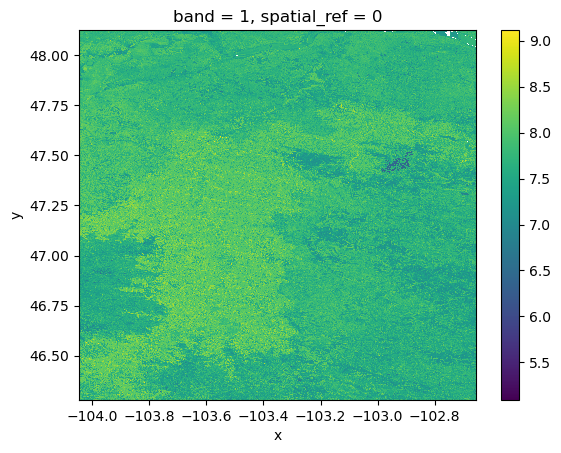

In [224]:
# Merge tiles
soil2_merged_das = merge_arrays(soil2_das)
soil2_merged_das.plot()

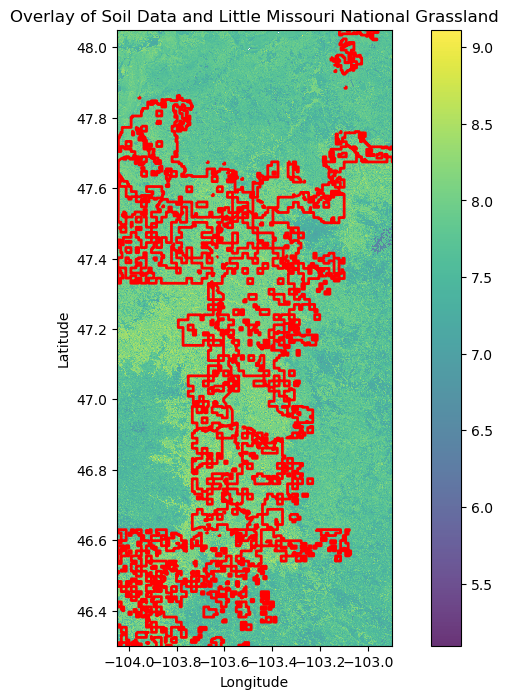

In [232]:
# Create a plot
fig2, ax = plt.subplots(figsize=(10, 8))

# Plot the raster data (soil1_da)
soil2_merged_das.plot(ax=ax, cmap="viridis", alpha=0.8)  # Adjust alpha for transparency

# Plot the boundaries of the vector data (habitat1_gdf)
habitat2_gdf.boundary.plot(ax=ax, color='red', linewidth=2)

# Add title and labels
ax.set_title("Overlay of Soil Data and Little Missouri National Grassland")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Adjust boundaries of data
xmin, xmax = -104.05, -102.9  
ymin, ymax = 46.3, 48.05    
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Show the plot
plt.show()

In [163]:
# Compile a regular expression to search for metadata
uri_re = re.compile(
    r"^http://hydrology\.cee\.duke\.edu/POLARIS/PROPERTIES/v1\.0/([a-z]+)/([a-z]+)/([0-9_]+)/lat([0-9]{4})_lon(-?[0-9]{3})-(-?[0-9]{3})\.tif$"
)
uri_re.search(soil2_files[6]).groupdict()

# Find all the metadata in the file name
uri_groups = [
   uri_re.search(soil2_file).groupdict()
   for soil2_file in soil2_files]

# Create a DataFrame with the metadata
soil2_df = pd.DataFrame(uri_groups)

# Add the File-like URI to the DataFrame
soil2_df['file'] = soil2_files

# Check the results
soil2_df

,file
0,http://hydrology.cee.duke.edu/POLARIS/PROPERTI...
1,http://hydrology.cee.duke.edu/POLARIS/PROPERTI...
2,http://hydrology.cee.duke.edu/POLARIS/PROPERTI...
3,http://hydrology.cee.duke.edu/POLARIS/PROPERTI...
4,http://hydrology.cee.duke.edu/POLARIS/PROPERTI...
5,http://hydrology.cee.duke.edu/POLARIS/PROPERTI...
6,http://hydrology.cee.duke.edu/POLARIS/PROPERTI...
7,http://hydrology.cee.duke.edu/POLARIS/PROPERTI...
8,http://hydrology.cee.duke.edu/POLARIS/PROPERTI...


In [ ]:
# Define download URL template for the soil data

# Prepare URL and file path for download
soil_url = (
    
)
soil1_dir = os.path.join(project_dir, 'hls')

if not glob(os.path.join(soil1_dir, '*.tif')):
    # Download sample raster data
    soil1_response = requests.get(soil1_url)

    # Save the raster data (uncompressed)
    with zipfile.ZipFile(BytesIO(soil1_response.content)) as soil1_zip:
        soil1_zip.extractall(soil1_dir)

# List out all soil files needed for download

output_da_list = [  ]

# Loop through each of the soil files (more info in redlining 92)

    # Download raster data

    # Extract metadata from the file name
        # Compile a regular expression to search for metadata
        uri_re = re.compile(
            r"HLS\.L30\.(?P<tile_id>T[0-9A-Z]+)\.(?P<date>\d+)T\d+\.v2\.0\.(?P<band_id>.+)\.tif"
        )
        # Find all the metadata in the file name
        uri_groups = [
        uri_re.search(denver_file.full_name).groupdict()
        for denver_file in denver_files]
    

    # Unzip the raster data

    # Only download once -- Save raster data to the disk

    # Load the raster data into Python, mask, and scale.

    def process_image(uri, bounds_gdf):
    """
    Load, crop, and scale a raster image from earthaccess

    Parameters
    ----------
    uri: file-like or path-like
      File accessor downloaded or obtained from earthaccess
    bounds_gdf: gpd.GeoDataFrame
      Area of interest to crop to

    Returns
    -------
    cropped_da: rxr.DataArray
      Processed raster
    """
    # Connect to the raster image
    da = rxr.open_rasterio(uri, mask_and_scale=True).squeeze()

    # Get the total boundary
    # Make sure that the CRSs match between vector and raster data (Get the study bounds section)
    bounds = (
      bounds_gdf
      .to_crs(da.rio.crs)
      .total_bounds
)

    # Crop the raster data

    cropped_da = da.rio.clip_box(*bounds)

    return cropped_da

    process_image(denver_files[8], denver_redlining_gdf)

    

  
output_da_list.append(cropped_da)

# merge tiles

denver_merged_das = {
    band_name: merge_arrays(das) 
    for band_name, das 
    in denver_das.items()}



# Make a plot to check the download (don't need to make a cloud mask), load in multiple bands, or calcualte the spectral indices
    denver_merged_das['green'].plot(cmap='Greens', robust=True)

In [ ]:
# Merge tile

# Plot a merged raster band
denver_merged_das['green'].plot(cmap='Greens', robust=True)